## Introduction
YouTube (the world-famous video sharing website) maintains a list of the top trending videos on the platform. According to Variety magazine,

“To determine the year’s top-trending videos, YouTube uses a combination of factors including measuring users interactions (number of views, shares, comments and likes). Note that they’re not the most-viewed videos overall for the calendar year”. Understanding the patterns in these video can aid in running a successful youtube channel.

### Aim
**To understand trends and patterns in dataset to help business team make decisions**

## Load Libraries and data

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
!pip install stop_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32912 sha256=d32ae9e0346680314a8ad3d0ce7a42cc97a7fcd5ccfb5f7cd77ee8dde573c6b5
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns
import plotly.graph_objects as go 
import plotly.express as px 
import warnings
warnings.filterwarnings('ignore')
import re
import string
from nltk.tokenize import word_tokenize
from stop_words import get_stop_words
import wordcloud
from nltk.corpus import stopwords
from collections import Counter

In [3]:
CA = pd.read_csv("CAvideos.csv", error_bad_lines=False,sep=';')
GB = pd.read_csv("GBvideos.csv", error_bad_lines=False,sep=';')
US = pd.read_csv("USvideos.csv", error_bad_lines=False,sep=';')
categories = pd.read_csv("categories.csv",sep=';')

In [4]:
print(f"The Canada dataset has {CA.shape[1]} rows and {CA.shape[0]} columns")
print(f"The Great Britian dataset has {GB.shape[1]} rows and {GB.shape[0]} columns")
print(f"The USA dataset has {US.shape[1]} rows and {US.shape[0]} columns")

The Canada dataset has 17 rows and 26039 columns
The Great Britian dataset has 17 rows and 29652 columns
The USA dataset has 17 rows and 29514 columns


## Merge dataset and deal with missing values

In [5]:
data = pd.concat([CA,GB,US], ignore_index=True)

In [6]:
print(f"The  merged dataset has {data.shape[1]} rows and {data.shape[0]} columns")

The  merged dataset has 17 rows and 85205 columns


In [7]:
data_description = pd.DataFrame({"Missing values"  :data.isna().sum()})

In [8]:
data_description

,Missing values
video_id,0
trending_date,6240
title,6240
channel_title,6413
publish_time,7591
views,7591
likes,7591
dislikes,7591
comment_count,7591
thumbnail_link,7591


In [9]:
#Drop missing values
data.dropna(inplace=True)

In [10]:
print(f"The merged dataset  now has {data.shape[1]} rows and {data.shape[0]} columns after dropping nans")

The merged dataset  now has 17 rows and 72167 columns after dropping nans


In [11]:
data = data.merge(categories, on ='category_id')

## Cleaning the data and creating new columns

In [12]:
data['trending_date'] = pd.to_datetime(data['trending_date'],errors='coerce', format='%y.%d.%m')
data['publish_time'] = pd.to_datetime(data['publish_time'], errors='coerce', format='%Y-%m-%dT%H:%M:%S.%fZ')
data['publish_date'] = pd.to_datetime(data['publish_time'].dt.date)

In [13]:
data['description'] = data['description'].apply(lambda text: str(text).lower())
data['title'] = data['title'].apply(lambda text: str(text).lower())
data['country'] = data['country'].apply(lambda text: str(text).lower())
data['engagement'] =data['likes']+ data['dislikes'] + data['comment_count']
data['title_length'] = data['title'].apply(lambda text: len(text))

## Data analysis

In [14]:
data['trending_date'].max() ,data['trending_date'].min()

(Timestamp('2018-04-03 00:00:00'), Timestamp('2017-11-14 00:00:00'))

In [15]:
data['trending_date'].max()- data['trending_date'].min()

Timedelta('140 days 00:00:00')

The dataset was collected from 14th November, 2017 to  14th June 2018 , that is a total of 212 days

### Country analysis

#### Percentage of trending videos in each country

In [16]:
new_data_1 = data.sort_values('trending_date', ascending=True, ignore_index=True).drop_duplicates(['video_id','country'], keep='first')

In [17]:
df = new_data_1.groupby(by=["country"]).size().reset_index(name="counts")

In [18]:
df = new_data_1.groupby(by=["country"]).size().reset_index(name="counts")
df['percent'] = df['counts']/sum(df['counts'])*100
fig = px.pie(df, values='percent', names='country', 
             color_discrete_sequence= ['#01233c', '#c3d4ca',], labels= {'sex_total': 'Total'}, template= 'ggplot2')
fig.update_layout(
     title = "Distribution of  trending videos in countries ",
     title_font_size = 16, legend_font_size =12,title_x =0.05,
     yaxis=dict(type='linear'), autosize=False,
    width=1200,
    height=600,
    margin=dict(
        l=50,
        r=200,
        b=100,
        t=100,
        pad=4
    ),legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01))
fig.update_xaxes(title=None,
     title_font=dict(size=14, family='Verdana', color='black'))
fig.update_yaxes(
     title_text = 'Number of trending videos',range = (0,30000),
     title_font=dict(size=14,family='Verdana', color='black'))

fig.update_xaxes(type='category')
fig.update_yaxes( showticklabels=False)

71.2 percent of videos were trending in Canada, 18.8 percent in United states  of America and 10 percent in  Great Britian

There is no noticeable trend in the ratings, views and comments between different countries

#### How are these videos splitted into different categories?

In [19]:
df= new_data_1.groupby(by=["country",'category_title_lvl_0'],as_index=False).size()
conditions = [
    (df['country']=='ca'),
    (df['country']=='gb'),
    (df['country']=='us')]
values = [
          round(df['size']/21864*100,2), 
          round(df['size']/3071*100,2),
          round(df['size']/5785*100,2)]
df['proportion'] = np.select(conditions, values)
fig=px.bar(df,y='proportion',color='category_title_lvl_0',x ='country',barmode='group',template= "xgridoff",labels={ "type": ""})
fig.update_layout(
     title = " Video  trending distribution  by categories",
     title_font_size = 16, legend_font_size =12,title_x =0.05,
     yaxis=dict(type='linear'), autosize=False,
    width=1200,
    height=600,
    margin=dict(
        l=50,
        r=200,
        b=100,
        t=100,
        pad=4
    ))
fig.update_xaxes(title=None,
     title_font=dict(size=14, family='Verdana', color='black'))
fig.update_yaxes(
     title_text = 'Number of trending videos',range = (0,100),
     title_font=dict(size=14,family='Verdana', color='black'))

fig.update_xaxes(type='category')

fig.show()

Entertainment videos are very popular amongst the 3 countries,  followed by other categories

#### How many likes, dislikes , comments and views  do vidoes get in diffferent countries?

In [20]:
df = data.sort_values('trending_date', ascending=True, ignore_index=True).drop_duplicates(['video_id','country'], keep='last')
df.groupby(by=["country"],as_index=False)['views','likes','dislikes','comment_count'].mean()

,country,views,likes,dislikes,comment_count
0,ca,8.614684e+05,27118.241598,1388.206004,3517.252291
1,gb,3.928919e+06,85513.700794,4964.550773,8463.305056
2,us,1.411760e+06,43056.775465,2413.092117,5059.973649


#### Can a video trend in 2 or more  countries?

In [21]:
df = new_data_1.copy() 
df= pd.get_dummies(df, columns=['country'])
new_df = df.groupby(['video_id','title'],as_index=False)['country_ca','country_gb','country_us'].sum()
new_df['total_countries'] = new_df['country_us'] +new_df['country_gb']+new_df['country_ca']


In [22]:
df = new_df['total_countries'].value_counts().rename_axis('No of countries').to_frame('counts').reset_index(level=0)
fig=px.bar(df ,x='No of countries', y='counts',color_discrete_sequence= ['#01233c'],template= "xgridoff",text='counts')
fig.update_layout(
     title = "Cross country video  trending distribution",
     title_font_size = 16, legend_font_size =12,title_x =0.05,
     yaxis=dict(type='linear'), autosize=False,
    width=1200,
    height=600,
    margin=dict(
        l=50,
        r=200,
        b=100,
        t=100,
        pad=4
    ),legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01))
fig.update_xaxes(title=None,
     title_font=dict(size=14, family='Verdana', color='black'))
fig.update_yaxes(
     title_text = 'Number of trending videos',range = (0,30000),
     title_font=dict(size=14,family='Verdana', color='black'))

fig.update_xaxes(type='category')
fig.update_yaxes( showticklabels=False)

Out of 27231 trending videos , 24,300 videos trended in only one country while the rest trended in 2 or 3 countries, you notice cross country video trending.

### Categories and Engagements

#### Which video category has the largest number of trending videos?

In [23]:
df=new_data_1["category_title_lvl_0"].value_counts().rename_axis('categories').to_frame('counts').reset_index(level=0)
fig=px.bar(df ,x='categories', y='counts',color_discrete_sequence= ['#01233c'],template= "xgridoff",text='counts')
fig.update_layout(
     title = " Video  trending distribution  by categories",
     title_font_size = 16, legend_font_size =12,title_x =0.05,
     yaxis=dict(type='linear'), autosize=False,
    width=1200,
    height=600,
    margin=dict(
        l=50,
        r=200,
        b=100,
        t=100,
        pad=4
    ),legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01))
fig.update_xaxes(title=None,
     title_font=dict(size=14, family='Verdana', color='black'))
fig.update_yaxes(
     title_text = 'Number of trending videos',range = (0,30000),
     title_font=dict(size=14,family='Verdana', color='black'))

fig.update_xaxes(type='category')
fig.update_yaxes( showticklabels=False)

#### Top 5 Categories by likes

In [24]:
df = new_data_1
df = df.groupby('category_title_lvl_0',as_index=False)['views', 'likes','dislikes','comment_count','engagement'].apply(lambda x: x.astype(int).sum())
df_likes = df[['category_title_lvl_0','likes']].sort_values(by='likes', ascending=False).head()


In [25]:
fig=px.bar(df_likes ,x='category_title_lvl_0', y='likes',color_discrete_sequence= ['#01233c'],template= "xgridoff",text='likes')
fig.update_layout(
     title = "Top 5 categories by likes",
     title_font_size = 16, legend_font_size =12,title_x =0.05,
     yaxis=dict(type='linear'), autosize=False,
    width=1200,
    height=600,
    margin=dict(
        l=50,
        r=200,
        b=100,
        t=100,
        pad=4
    ),legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01))
fig.update_xaxes(title=None,
     title_font=dict(size=14, family='Verdana', color='black'))
fig.update_yaxes(
     title_text = 'Number of trending videos',range = (0,500000000),
     title_font=dict(size=14,family='Verdana', color='black'))

fig.update_xaxes(type='category')
fig.update_yaxes( showticklabels=False)

#### Top 5  Categ0ries by views

In [26]:
df_views = df[['category_title_lvl_0','views']].sort_values(by='views', ascending=False).head()

In [27]:
fig=px.bar(df_views ,x='category_title_lvl_0', y='views',color_discrete_sequence= ['darkred'],template= "xgridoff",text='views')
fig.update_layout(
     title = "Top 5 categories by views",
     title_font_size = 16, legend_font_size =12,title_x =0.05,
     yaxis=dict(type='linear'), autosize=False,
    width=1200,
    height=600,
    margin=dict(
        l=50,
        r=200,
        b=100,
        t=100,
        pad=4
    ),legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01))
fig.update_xaxes(title=None,
     title_font=dict(size=14, family='Verdana', color='black'))
fig.update_yaxes(
     title_text = 'Number of trending videos',range = (0,20000000000),
     title_font=dict(size=14,family='Verdana', color='black'))

fig.update_xaxes(type='category')
fig.update_yaxes( showticklabels=False)

#### Top 5 categories by comments

In [28]:
df_comments = df[['category_title_lvl_0','comment_count']].sort_values(by='comment_count', ascending=False).head()

In [29]:
fig=px.bar(df_comments ,x='category_title_lvl_0', y='comment_count',color_discrete_sequence= ['darkred'],template= "xgridoff",text='comment_count')
fig.update_layout(
     title = "Top 5 categories by comments",
     title_font_size = 16, legend_font_size =12,title_x =0.05,
     yaxis=dict(type='linear'), autosize=False,
    width=1200,
    height=600,
    margin=dict(
        l=50,
        r=200,
        b=100,
        t=100,
        pad=4
    ),legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01))
fig.update_xaxes(title=None,
     title_font=dict(size=14, family='Verdana', color='black'))
fig.update_yaxes(
     title_text = 'Number of trending videos',range = (0,80000000),
     title_font=dict(size=14,family='Verdana', color='black'))

fig.update_xaxes(type='category')
fig.update_yaxes( showticklabels=False)

#### Top 5 trending videos by dislikes

In [30]:
df_dislikes = df[['category_title_lvl_0','dislikes']].sort_values(by='dislikes', ascending=False).head()

In [31]:
fig=px.bar(df_dislikes ,x='category_title_lvl_0', y='dislikes',color_discrete_sequence=['darkred'],template= "xgridoff",text='dislikes')
fig.update_layout(
     title = "Top 5 categories by dislikes",
     title_font_size = 16, legend_font_size =12,title_x =0.05,
     yaxis=dict(type='linear'), autosize=False,
    width=1200,
    height=600,
    margin=dict(
        l=50,
        r=200,
        b=100,
        t=100,
        pad=4
    ),legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01))
fig.update_xaxes(title=None,
     title_font=dict(size=14, family='Verdana', color='black'))
fig.update_yaxes(
     title_text = 'Number of trending videos',range = (0,50000000),
     title_font=dict(size=14,family='Verdana', color='black'))

fig.update_xaxes(type='category')
fig.update_yaxes( showticklabels=False)

Entertainment and Music are the top trending categories

#### Did videos that have 0 engagement make it to the trending list?

In [32]:
new_data_2 = data.drop_duplicates(['video_id','publish_time'])
print(f"There are {new_data_2[new_data_2['engagement']==0]['video_id'].nunique()} videos on the trending list with 0 engagements")

There are 32 videos on the trending list with 0 engagements


##### Example of such video

---



In [33]:
new_data_2[new_data_2['engagement']==0].head(1).T

,281
video_id,nx1R-eHSkfM
trending_date,2017-11-30 00:00:00
title,the new snapchat in 60 seconds
channel_title,Snapchat
publish_time,2017-11-29 14:00:03
views,867588
likes,0
dislikes,0
comment_count,0
thumbnail_link,https://i.ytimg.com/vi/nx1R-eHSkfM/default.jpg


#### Were the rating of  videos who had zero engagements disable?

In [34]:
df = new_data_2[new_data_2['engagement']==0]['ratings_disabled'].value_counts().rename_axis('Ratings_disabled').to_frame('counts').reset_index(level=0)
df['percent'] = df['counts']/sum(df['counts'])*100
fig = px.pie(df, values='percent', names='Ratings_disabled', 
             color_discrete_sequence= ['#01233c', '#c3d4ca',], labels= {'sex_total': 'Total'}, template= 'ggplot2')
fig.update_layout(
     title = "Ratings Disabled for videos with zero engagements ",
     title_font_size = 16, legend_font_size =12,title_x =0.05,
     yaxis=dict(type='linear'), autosize=False,
    width=1200,
    height=600,
    margin=dict(
        l=50,
        r=200,
        b=100,
        t=100,
        pad=4
    ),legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01))
fig.update_xaxes(title=None,
     title_font=dict(size=14, family='Verdana', color='black'))
fig.update_yaxes(
     title_text = 'Number of trending videos',range = (0,30000),
     title_font=dict(size=14,family='Verdana', color='black'))

fig.update_xaxes(type='category')
fig.update_yaxes( showticklabels=False)

91.3 percent videos  that has zero engagements had their ratings disabled , this justifies  why they have zero engagements

#### what channels had the  trending videos with the  0 engagements?

In [35]:
pd.DataFrame(new_data_2[new_data_2['engagement']==0]['channel_title'].unique())

,0
0,Snapchat
1,On n'est pas couché
2,DowntownDubai
3,Geek & Sundry
4,Difficult Psycho
5,Dancing On Ice
6,HARRY
7,American Bridge 21st Century
8,Kylie Jenner
9,Steve Kovach


### Video trending  and  Duration

In [36]:
last_data =  data.sort_values('trending_date', ascending=True, ignore_index=True).drop_duplicates(['video_id','publish_time'], keep='last')
first_data =  data.sort_values('trending_date', ascending=True, ignore_index=True).drop_duplicates(['video_id','publish_time'], keep='first')
first_data['start_trending_date'] = first_data['trending_date']
last_data['end_trending_date'] = last_data['trending_date']
first_data.drop('trending_date',1,inplace=True)
last_data.drop('trending_date',1,inplace=True)
new_data_4 = first_data.merge(last_data[['video_id','end_trending_date']], on='video_id')
new_data_4['trending_duration'] = (new_data_4['end_trending_date'] - new_data_4['start_trending_date']).dt.days
new_data_4['days_to_trending']=(new_data_4['start_trending_date'] -new_data_4['publish_date']).dt.days

#### How long does  a video  trend?

In [37]:

fig=px.box(new_data_4,y='trending_duration',color_discrete_sequence= ['#01233c'],template= "xgridoff")
fig.update_layout(
     title = "Videos Trending Duration",
     title_font_size = 16, legend_font_size =12,title_x =0.05,
     yaxis=dict(type='linear'), autosize=False,
    width=1200,
    height=600,
    margin=dict(
        l=50,
        r=200,
        b=100,
        t=100,
        pad=4
    ),legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01))
fig.update_xaxes(title=None,
     title_font=dict(size=14, family='Verdana', color='black'))
fig.update_yaxes(
     title_text = 'Duration',range = (0,40),
     title_font=dict(size=14,family='Verdana', color='black'))

fig.update_xaxes(type='category')
fig.update_yaxes( showticklabels=True)

#### What video remained the most on the trending list?

In [38]:
new_data_4[new_data_4['trending_duration'] == new_data_4['trending_duration'].max()]

,video_id,title,channel_title,publish_time,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,tags,category_id,category_id_lvl_0,category_id_lvl_1,category_id_lvl_2,category_title_lvl_0,category_title_lvl_1,category_title_lvl_2,publish_date,engagement,title_length,start_trending_date,end_trending_date,trending_duration,days_to_trending
11723,BhIEIO0vaBE,to our daughter,Kylie Jenner,2018-02-04 20:27:38,20921796.0,0.0,0.0,0.0,https://i.ytimg.com/vi/BhIEIO0vaBE/default.jpg,True,True,False,directed by tyler ross @wttyler\nmusic by jaco...,us,",'kylie jenner','kylie','travis scott','baby',...",804.0,800,804.0,NaN,Entertainment,People & Blogs,NaN,2018-02-04,0.0,15,2018-02-05,2018-03-14,37,1
11730,NooW_RbfdWI,jurassic world: fallen kingdom - official trai...,Universal Pictures,2018-02-04 23:28:16,1999326.0,61833.0,1416.0,6400.0,https://i.ytimg.com/vi/NooW_RbfdWI/default.jpg,False,False,False,jurassic world: fallen kingdom \nin theaters j...,gb,",'jurassic world','fallen kingdom','dinosaur',...",806.0,800,806.0,NaN,Entertainment,Other Entertainment,NaN,2018-02-04,69649.0,57,2018-02-05,2018-03-14,37,1
11786,2z3EUY1aXdY,justin timberlake’s full pepsi super bowl lii ...,NFL,2018-02-05 01:51:53,2027569.0,50251.0,15238.0,14413.0,https://i.ytimg.com/vi/2z3EUY1aXdY/default.jpg,False,False,False,justin timberlake breaks it down during the pe...,us,",'nfl','football','offense','defense','afc','n...",802.0,800,802.0,NaN,Entertainment,Sports,NaN,2018-02-05,79902.0,77,2018-02-05,2018-03-14,37,0


### How does views ,likes, comments, and shares correlate?

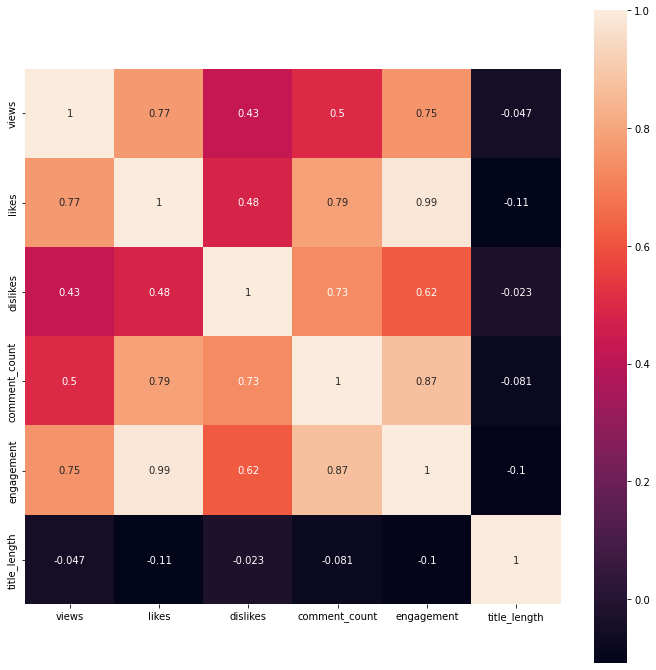

In [39]:
columns_show=['views', 'likes', 'dislikes', 'comment_count','engagement', 'title_length']
f, ax = plt.subplots(figsize=(12, 12))
corr = data[columns_show].corr()
sns.heatmap(corr,
            square=True, ax=ax,annot=True);

* Likes and dislikes are positively correlated to  comment count which means as 
the likes and dislikes increase/ decrease there is an equal tendency for the comment to increase/decrease or vice versa
* Views  and likes  positively correlated.
* Engagement which includes likes, commemts and dislikes is postively correlated to the viewes 

### Text analytics

In [40]:
def preprocess_text(text):
    
    """
    Function to preprocess text: removes links, punctuation, spaces, non-alpha words and stop_words
    
    Parameters
    ----------
    text(str): a string to be preprocessed
        
    Returns
    -------
    text(str):a preprocessed string
    """
    text = text.lower()                                    #lowercase
    text = re.sub(r"http\S+", "", text)                    #replace links with ""
    text=re.sub("!", "", text)
    text = re.compile('[/(){}\[\]\|,;&-_]').sub("", text) #replace punctuations with ""
    text = [word.strip() for word in text.split()]         #strip space from words
    text = [word for word in text if len(word)>2]          #removing words less than 2 characters
    text = [word for word in text if word not in get_stop_words('en')and word  not  in stopwords.words("english")]  #removing twitter amp and stop words
    # Remove numbers
    text = [word for word in text if not word.isnumeric()]        

    text = ' '.join(text)
    return text

In [41]:
def tokenizer(text):
    """ splits sentences into individual words using a delimeter

    Parameters:
    text(str):sentence

    Returns:
    str : splited words in a list
    """
   
    text=text.apply(word_tokenize)
    
    return text

#### Frequent words in title

In [42]:
df_text = data.copy()
df_text=df_text.sort_values('trending_date', ascending=True, ignore_index=True).drop_duplicates(['title','country'], keep='first')

In [43]:
df_text['title'] = df_text['title'].apply(preprocess_text)
df_text['title'] = df_text['title'].apply(word_tokenize)

In [44]:
title_words = list(df_text["title"])
title_words = [x for y in title_words for x in y]
Counter(title_words).most_common(10)

[('episode', 1140),
 ('official', 1105),
 ('video', 893),
 ('full', 818),
 ('new', 633),
 ('’', 598),
 ('trump', 595),
 ('trailer', 566),
 ('game', 497),
 ('music', 466)]

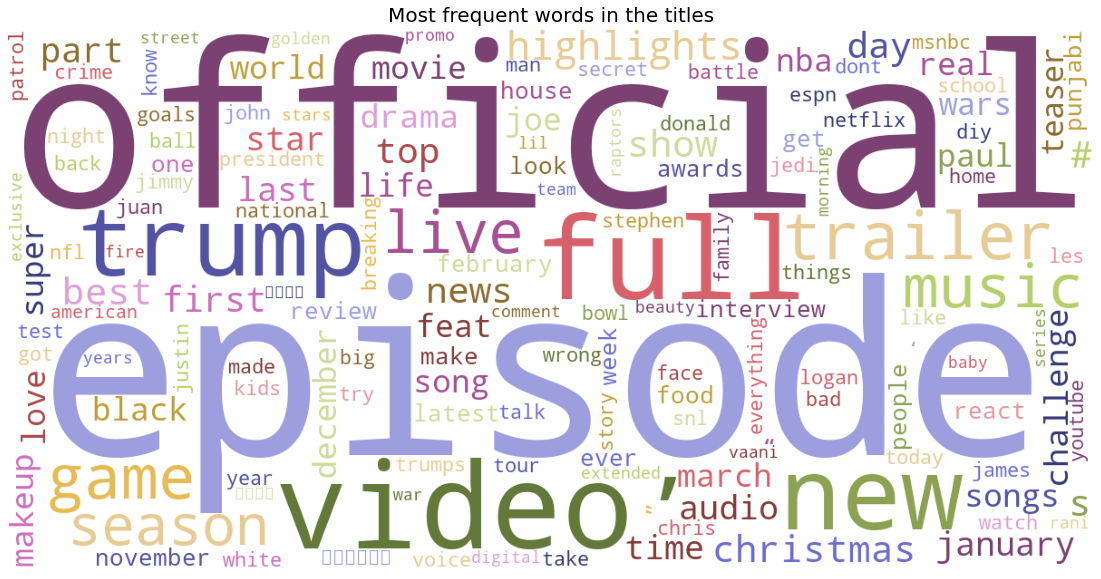

In [45]:
title_cloud = wordcloud.WordCloud(width=1200, height=600, collocations=False, stopwords=None, background_color="white", colormap="tab20b").generate_from_frequencies(dict(Counter(title_words).most_common(150)))
plt.figure(figsize=(30,10))
plt.imshow(title_cloud)
plt.axis("off")
plt.title("Most frequent words in the titles",fontsize=20)
plt.show()

The video title contained official, episode, video, full, new , most frequently 

#### Frequent words in tags

In [46]:
df_text['tags'] = df_text['tags'] . apply(word_tokenize)

In [47]:
tag_words = list(df_text["tags"])
tag_words = [x for y in tag_words for x in y if len(x)>2 and  x not in get_stop_words('en') and x not in stopwords.words("english")]
Counter(tag_words).most_common(10)

[("'the", 6001),
 ("'funny", 3608),
 ('show', 3563),
 ('news', 3403),
 ('video', 2559),
 ("'new", 2504),
 ('2018', 2342),
 ("'comedy", 2142),
 ('2017', 2053),
 ('songs', 1820)]

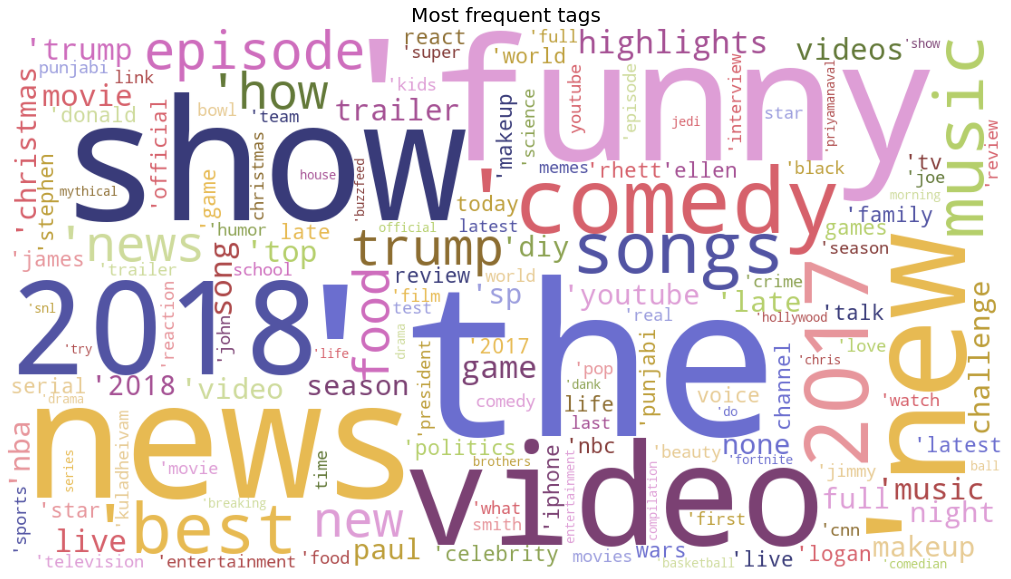

In [48]:
plt.figure(figsize=(30,10))
tag_cloud= wordcloud.WordCloud(width=1100,height=600,background_color="white", colormap="tab20b").generate_from_frequencies(dict(Counter(tag_words).most_common(150)))
plt.imshow(tag_cloud)
plt.axis('off')
plt.title("Most frequent tags",fontsize=20)
plt.show()

News , funny ,show, new , video , 2018 which is the publish year are the most frequent tags used and can be  recommended to be used for new videos

## Conclusion



*    Most users genrally  and watch engage with entertainment add music more than the other categories. Entertainment has the highest number of trending videos.
*   This dataset doenot show if a  country  influences whether a video will be trending or nnot. Although some videos trened in multiple countures at the same time.
 * Some videos had no engagement  are still trending. 91.4 percent of those videos had their ratings off, so even if viewers engaged the video , it wasnot recorded.
* There are 3 videos with the longest trending duration , 37days , although there are  still videos that trending only the day they were uploaded.
* Likes and dislikes are positively correlated to  comment count which means as 
the likes and dislikes increase/ decrease there is an equal tendency for the comment to increase/decrease or vice versa
* Views  and likes  positively correlated.
* Engagement which includes likes, commemts and dislikes is postively correlated to the viewes 
* Most frequent words  in video title include; official, episode, video, full, new
* Most frequent words in tags include; News , funny ,show, new , video .


